<a href="https://colab.research.google.com/github/jkitchin/dft-book-espresso/blob/master/02-molecules.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

Two of the most important quantities we are interested in are the total
energy and the forces on the atoms. To get these quantities, we have
to define a calculator and attach it to an `ase.Atoms` object so
that `ase` knows how to get the data. After defining the calculator a
DFT calculation must be run.

Here is an example of getting the energy and forces from a CO
molecule. The forces in this case are very high, indicating that this
geometry is not close to the ground state geometry. Note that the
forces are only along the $x$-axis, which is along the molecular axis. We will see how to minimize this force later.


# Setup colab

In [1]:
! pip install --upgrade dftbook
import dftbook
dftbook.setup_colab()

Please be patient. This takes about 30 seconds.
Installing quantum espresso
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Setup is complete. Please visit https://drive.google.com/drive/folders/1fVOol26JssnCRXv_3EVgsbk3Z5jd60Nl to find the tutorials.


# Your first DFT calculation

There are two parts to every DFT calculation with ASE. First, we setup the Atoms object that contains the geometry, then the calculator. You have to set the calculator on the Atoms object, and then you can get properties like the energy and forces.

We setup a calculator that uses a planewave cutoff of 350 eV, and the PBE exchange correlation functional. We only want the energy, so we specify a self-consistent field calculation.

No DFT calculation happens until you ask for a property, in this case the energy. The calculator should be smart enough to not run the calculation again if it is already done.

In [2]:
from ase import Atoms, Atom
from espresso import Espresso

co = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],
            cell=(6., 6., 6.))

#Use QE as a single-point calculator (just SCF)
calc = Espresso(pw=350.0, 
                calculation='scf',
                xc='PBE')

co.set_calculator(calc)
co.get_potential_energy()  # This triggers the DFT calculation

-593.6960610598508

That energy is not particularly useful by itself. We have no context to determine what it means. Let's get the forces next. 

In [3]:
co.get_forces()

array([[ 5.46386614,  0.        ,  0.        ],
       [-5.46386614,  0.        ,  0.        ]])

The forces here are in eV/angstrom, and they are very high. That means there is a better bond length that would have lower forces, and lower energy. We have to check a few more things first though. There are two parameters we need to understand the effect of on the energy. Those are:

1. The size of the unit cell
2. The planewave cutoff

There are periodic boundary conditions, so the CO molecule can interact with images in neighboring cells. We need to make sure the unit cell is large enough to minimize these interactions.

We also want to make sure the planewave cutoff is high enough that the energy and forces do not depend on it that much. 

## Convergence of the unit cell size
We will start with the unit cell size. To do this we need to make a list of atoms objects with different unit cells, and then get the energy of each one. Below I use list comprehensions for this.

Text(0, 0.5, 'Total energy (eV)')

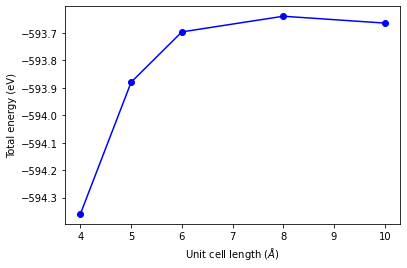

In [4]:
L = [4, 5, 6, 8, 10]

ATOMS = [Atoms([Atom('C', [0, 0, 0]),
                Atom('O', [1.2, 0, 0])],
                cell=(a, a, a)) for a in L]

# This list comprehension works by side effect
[atoms.set_calculator(Espresso(pw=350.0, 
                               calculation='scf',
                               xc='PBE'))
  for atoms in ATOMS]

energies = [atoms.get_potential_energy() for atoms in ATOMS]

import matplotlib.pyplot as plt
plt.plot(L, energies, 'bo-')
plt.xlabel('Unit cell length ($\AA$)')
plt.ylabel('Total energy (eV)')

We should also look at the forces. You can see these depend more strongly on the cell size, but again a unit cell larger than 6 angstroms has a pretty constant force.

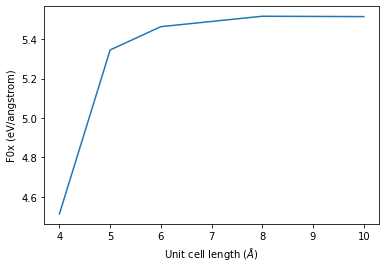

In [7]:
forces = [atoms.get_forces()[0, 0] for atoms in ATOMS]
plt.plot(L, forces)
plt.xlabel('Unit cell length ($\AA$)')
plt.ylabel('F0x (eV/angstrom)');

You can see that for unit cells bigger than about 6 angstroms, the energy does not change much. Larger unit cells are more expensive to compute though, so we do not want them to be larger than necessary.

## Planewave energy convergence

We use a similar approach for testing the planewave convergence. We look at the energy and forces here.

In [9]:
import numpy as np
PW = np.linspace(200, 400, 5)

ATOMS = [Atoms([Atom('C', [0, 0, 0]),
                Atom('O', [1.2, 0, 0])],
                cell=(6, 6, 6)) for pw in PW]

# This list comprehension works by side effect
[ATOMS[i].set_calculator(Espresso(pw=pw, 
                               calculation='scf',
                               xc='PBE'))
  for i, pw in enumerate(PW)]

import time
energies = []

for i, pw in enumerate(PW):
  t0 = time.time()
  atoms = ATOMS[i]
  energies += [atoms.get_potential_energy()]
  print(f'Elapsed time for pw={pw} = {time.time() - t0:1.1f} sec.')

Elapsed time for pw=200.0 = 4.0 sec.
Elapsed time for pw=250.0 = 5.2 sec.
Elapsed time for pw=300.0 = 7.0 sec.
Elapsed time for pw=350.0 = 8.2 sec.
Elapsed time for pw=400.0 = 9.2 sec.


You can see that higher planewave cutoffs are more expensive than smaller ones. Again, we have to find a compromise here. The times here are very small because we have only a CO molecule. But, the time range here is relevant, because it can be the difference between 1 hour or 2 hours, or days, etc.

It is always necessary to check this. You may find some guidelines in the files at http://www.quantum-espresso.org/pseudopotentials.

Text(0, 0.5, 'Total energy (eV)')

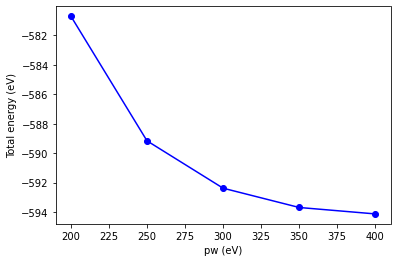

In [10]:
plt.plot(PW, energies, 'bo-')
plt.xlabel('pw (eV)')
plt.ylabel('Total energy (eV)')

The energy is changing a lot here, and even at 400 is not considered converged. That is not surprising, C and O are considered "hard" and probably need a cutoff greater than 500 eV to be considered converged. We will not worry about that here. It is also usually not the total energy we need to be worried about, but rather some difference in energies. Note below, that the derivative (which is like a difference) converges rather quickly.

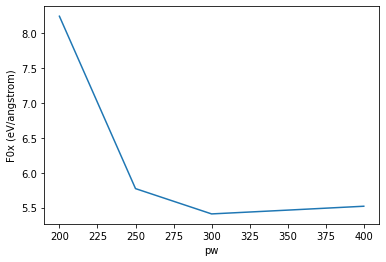

In [12]:
forces = [atoms.get_forces()[0, 0] for atoms in ATOMS]
plt.plot(PW, forces)
plt.xlabel('pw')
plt.ylabel('F0x (eV/angstrom)');

# Introduction to geometry optimization

In the example above, we saw that the forces were high. That means there is a bond length where the energy is lower. We explored the convergence of two calculation parameters, and saw that a unit cell of at least 6 angstroms is a minimally reasonable choice, and that the forces are reasonably converged at 350 eV. We would not publish results like this, but they are ok to see how this works.

## Manual determination of optimal bond length
First, we will compute the energy and forces for a series of bond lengths.

In [13]:
bond_lengths = [1.05, 1.1, 1.15, 1.2, 1.25]

ATOMS = [Atoms([Atom('C', [0, 0, 0]),
                Atom('O', [d, 0, 0])],
                cell=(6, 6, 6)) for d in bond_lengths]

# This list comprehension works by side effect
[ATOMS[i].set_calculator(Espresso(pw=350, 
                               calculation='scf',
                               xc='PBE'))
  for i, d in enumerate(bond_lengths)]

import time
energies = []

for i, d in enumerate(bond_lengths):
  t0 = time.time()
  atoms = ATOMS[i]
  energies += [atoms.get_potential_energy()]
  print(f'Elapsed time for d={d} = {time.time() - t0:1.1f} sec.')


Elapsed time for d=1.05 = 8.3 sec.
Elapsed time for d=1.1 = 8.3 sec.
Elapsed time for d=1.15 = 8.2 sec.
Elapsed time for d=1.2 = 8.3 sec.
Elapsed time for d=1.25 = 8.2 sec.


Emin = -593.872 eV at d=1.140 angstroms


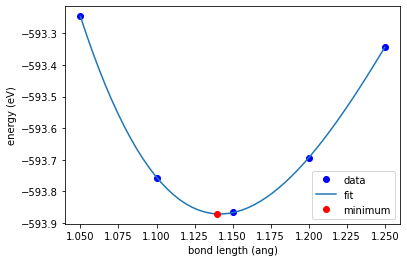

In [27]:
p = np.polyfit(bond_lengths, energies, 3)



bfit = np.linspace(1.05, 1.25)
efit = np.polyval(p, bfit)
imin = np.argmin(efit)
plt.plot(bond_lengths, energies, 'bo')
plt.plot(bfit, efit)
plt.plot(bfit[imin], efit[imin], 'ro')
plt.legend(['data', 'fit', 'minimum'])
plt.xlabel('bond length (ang)')
plt.ylabel('energy (eV)')

print(f'Emin = {efit[imin]:1.3f} eV at d={bfit[imin]:1.3f} angstroms')

A critical point to note here is that this minimum is also where the force changes sign from negative to positive, i.e. the force becomes zero.

Text(0, 0.5, 'Force (eV/ang)')

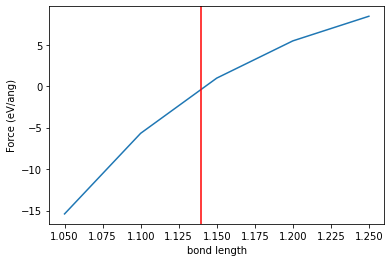

In [34]:
forces = [atoms.get_forces()[0, 0] for atoms in ATOMS]
plt.plot(bond_lengths, forces)
plt.axvline(bfit[imin], color='r')
plt.xlabel('bond length')
plt.ylabel('Force (eV/ang)')

This is only a reasonable way to approach geometry optimization because it is essentially a 1D optimization, i.e. the bond length. It is not how we usually approach geometry optimization. Next we discuss two approaches to automating this.

## Geometry optimization in ASE

ASE provides a way to automate the optimization. We setup an optimizer object, and then run it. We specify a convergence criteria, in this case we stop when the maximum force is less than 0.05 eV/angstrom.

In [35]:
co = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],
            cell=(6., 6., 6.))

#Use QE as a single-point calculator (just SCF)
calc = Espresso(pw=350.0, 
                calculation='scf',
                xc='PBE')

co.set_calculator(calc)

from ase.optimize import QuasiNewton
dyn = QuasiNewton(co)
dyn.run(fmax=0.05)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 12:46:42     -593.696061*       5.4639
BFGSLineSearch:    1[  2] 12:46:58     -593.868584*       0.1704
BFGSLineSearch:    2[  3] 12:47:06     -593.868699*       0.0422


True

That only took three iterations, which is less than the manual approach we used above. 

When it is done we can get the bond length from the atoms object.

In [36]:
co.get_distance(0, 1)

1.141729370561679

The total energy at this bond length is not the same as the one we estimated above, but it is close. The estimate above is from fitting, and the fit is probably not that accurate near the minimum.

In [37]:
co.get_potential_energy()

-593.8686994807175

Finally, we note that the forces are now low, and less than the tolerance we specified.

In [38]:
co.get_forces()

array([[ 0.04220055,  0.        ,  0.        ],
       [-0.04220055,  0.        ,  0.        ]])

## Optimization with Quantum Espresso

We can also let Quantum Espresso do the optimization for us. 

This does not seem to work.

In [43]:
co = Atoms([Atom('C', [0, 0, 0]),
            Atom('O', [1.2, 0, 0])],
            cell=(6., 6., 6.))

#Use QE as a single-point calculator (just SCF)
calc = Espresso(pw=350.0, 
                calculation='relax',
                ion_dynamics='relax',
                fmax=0.05,
                xc='PBE')
co.set_calculator(calc)
co.get_forces()

RuntimeError: ignored

# Exercises

Build a molecule using the tools from the first lecture, or from hand, and do a geometry optimization on it. Verify that the forces are all small. Compute bond lengths and angles and compare them to known values.
